In [1]:
# Library
import streamlit as st
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from sklearn.ensemble import RandomForestClassifier


In [2]:
# Membaca file dataset
dir = 'hungarian.data'
with open(dir, encoding='Latin1') as file:
    lines = [line.strip() for line in file]

In [3]:
# Menyusun data menjadi dataframe
data = itertools.takewhile(
    lambda x: len(x) == 76,
    (' '.join(lines[i:(i + 10)]).split() for i in range(0, len(lines), 10))
)
df = pd.DataFrame.from_records(data)
print(df.head())

  0  1   2  3   4   5   6   7  8    9   ... 66 67 68 69 70 71 72  73  74    75
0  1  0  63  1  -9  -9  -9  -9  1  145  ...  1  1  1  1  1  1  1  -9  -9  name
1  2  0  67  1  -9  -9  -9  -9  4  160  ...  1  1  1  1  1  1  1  -9  -9  name
2  3  0  67  1  -9  -9  -9  -9  4  120  ...  2  2  1  1  1  7  3  -9  -9  name
3  4  0  37  1  -9  -9  -9  -9  3  130  ...  1  1  1  1  1  1  1  -9  -9  name
4  6  0  41  0  -9  -9  -9  -9  2  130  ...  1  1  1  1  1  1  1  -9  -9  name

[5 rows x 76 columns]


In [4]:
# Mengganti nilai '-9' dengan NaN untuk missing values
df.replace('-9', np.nan, inplace=True)

# Menghapus kolom 'name' (kolom terakhir)
df.drop(columns=df.columns[-1], inplace=True)

In [5]:
# Memilih kolom yang relevan sesuai dengan indeks yang diberikan
selected_columns = [2, 3, 8, 9, 11, 15, 18, 31, 37, 39, 40, 43, 50, 57]
df = df.iloc[:, selected_columns]

# Menambahkan nama kolom
df.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 
              'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

In [6]:
# Memeriksa apakah terdapat nilai yang hilang (NaN) dalam dataset
print(df.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          2
thal        2
num         0
dtype: int64


In [7]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [8]:
# Mengganti nilai yang hilang dengan metode yang sesuai (misalnya, mengganti dengan nilai rata-rata untuk kolom numerik)
df.fillna(df.mean(), inplace=True)

# Untuk kolom yang mungkin lebih baik diisi dengan modus (misalnya kategori), kita bisa melakukan hal berikut:
for column in df.columns:
    if df[column].dtype == 'object':  # Jika tipe datanya adalah object (kategori)
        df[column].fillna(df[column].mode()[0], inplace=True)

# Memastikan tipe data yang sesuai
df = df.apply(pd.to_numeric, errors='ignore')

# Menampilkan informasi mengenai dataset setelah pembersihan
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       282 non-null    int64  
 1   sex       282 non-null    int64  
 2   cp        282 non-null    int64  
 3   trestbps  282 non-null    int64  
 4   chol      282 non-null    int64  
 5   fbs       282 non-null    int64  
 6   restecg   282 non-null    int64  
 7   thalach   282 non-null    int64  
 8   exang     282 non-null    int64  
 9   oldpeak   282 non-null    float64
 10  slope     282 non-null    int64  
 11  ca        282 non-null    int64  
 12  thal      282 non-null    int64  
 13  num       282 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 31.0 KB
None


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10800\1777654882.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.mean(), inplace=True)


In [9]:
# Memeriksa kembali apakah terdapat nilai yang hilang (NaN) dalam dataset
print(df.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


In [10]:
df.shape

(282, 14)

In [11]:
df["num"].unique()

array([0, 2, 1, 3, 4], dtype=int64)

In [12]:
# Cek korelasi antar kolom
print(df.corr()["num"].abs().sort_values(ascending=False))

num         1.000000
thal        0.501384
ca          0.501083
oldpeak     0.487529
exang       0.398880
thalach     0.396194
cp          0.383891
slope       0.367932
sex         0.239516
age         0.210747
restecg     0.187365
trestbps    0.151776
chol        0.098895
fbs         0.039690
Name: num, dtype: float64


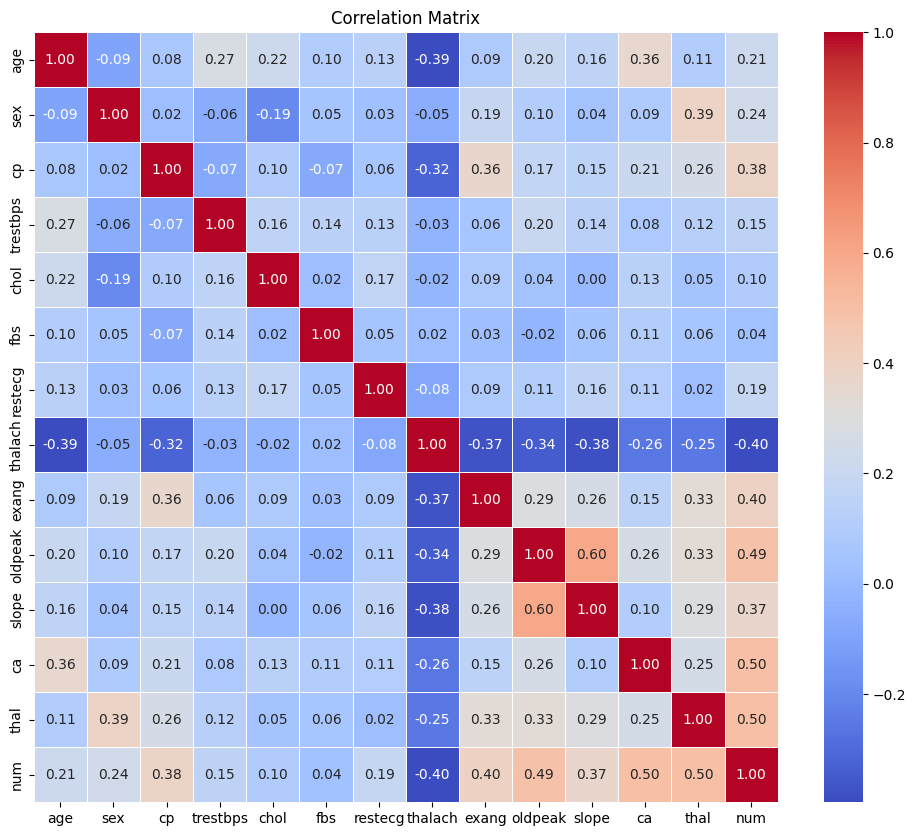

In [14]:
# Menghitung korelasi matriks
correlation_matrix = df.corr()

# Menampilkan korelasi matriks
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [15]:
# Analisis target
y = df["num"]
#sns.countplot(y)

target_temp = df.num.value_counts()
print(target_temp)

0    157
1     50
3     32
2     31
4     12
Name: num, dtype: int64


In [16]:
atribut = df.drop("num",axis=1)
target = df["num"]

X_train,X_test,Y_train,Y_test = train_test_split(atribut,target,test_size=0.20,random_state=0)

In [17]:
print(X_train.shape)
print(X_test.shape)

(225, 13)
(57, 13)


In [18]:
print(Y_train.shape)
print(Y_test.shape)

(225,)
(57,)


# Oversampling SMOTE

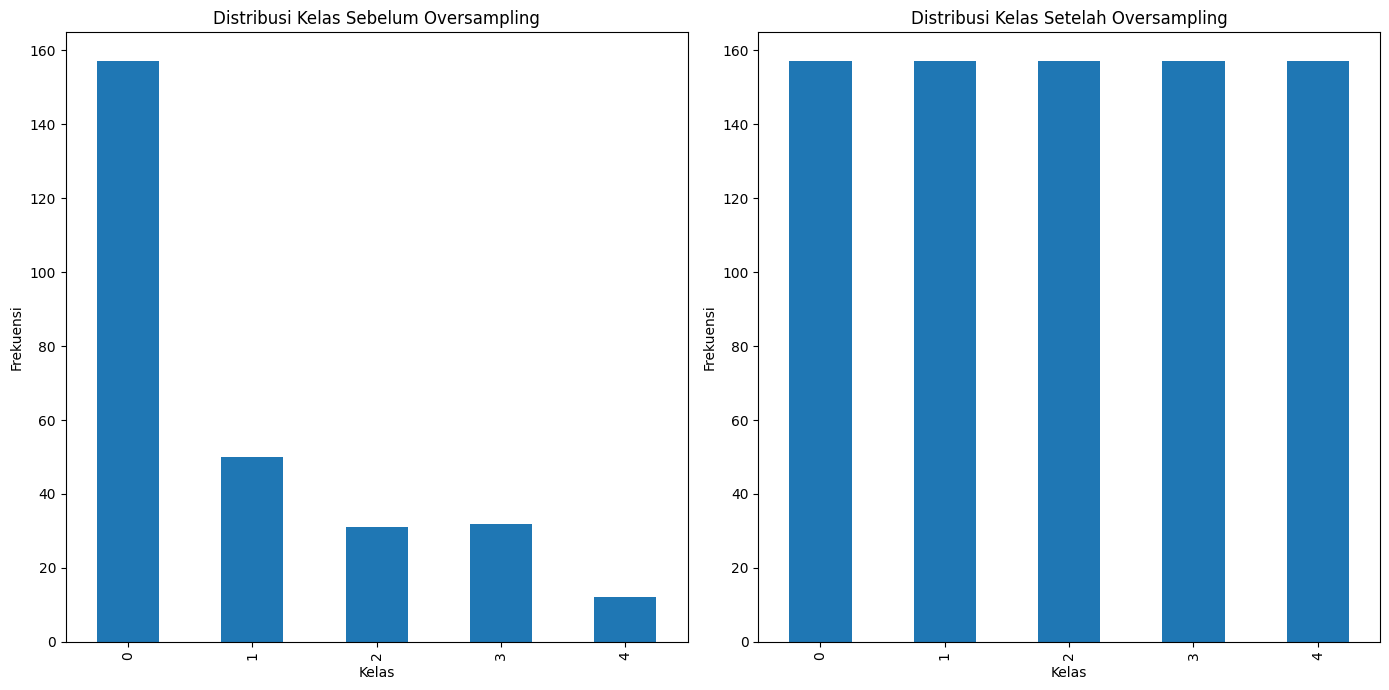

In [19]:
# Plot distribusi kelas sebelum oversampling
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
y.value_counts().sort_index().plot(kind='bar', title='Distribusi Kelas Sebelum Oversampling')
plt.xlabel('Kelas')
plt.ylabel('Frekuensi')

# Menerapkan SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(atribut, target)

# Plot distribusi kelas setelah oversampling
plt.subplot(1, 2, 2)
y_res.value_counts().sort_index().plot(kind='bar', title='Distribusi Kelas Setelah Oversampling')
plt.xlabel('Kelas')
plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()

In [20]:
## OPSIONAL
# Normalisasi atau standarisasi fitur jika diperlukan
scaler = StandardScaler()
X_res = scaler.fit_transform(X_res)

# Membagi data menjadi set pelatihan dan set pengujian
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


In [21]:
# LOGISTIC REGRESSION
lr = LogisticRegression()
lr.fit(X_train,y_train)
Y_pred_lr = lr.predict(X_test)

score_lr = round(accuracy_score(Y_pred_lr,y_test)*100,2)
print("Akurasi : "+str(score_lr)+" %")

Akurasi : 57.32 %


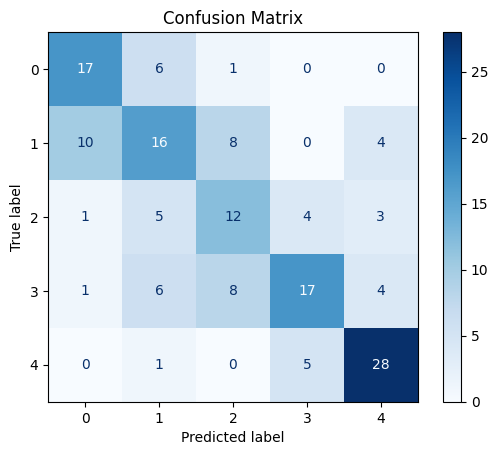

In [22]:
# Membuat confusion matrix model Logistic Regression
cm = confusion_matrix(y_test, Y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [23]:
# NAIVE BAYES
nb = GaussianNB()
nb.fit(X_train,y_train)
Y_pred_nb = nb.predict(X_test)

score_nb = round(accuracy_score(Y_pred_nb,y_test)*100,2)
print("Akurasi : "+str(score_nb)+" %")

Akurasi : 57.32 %


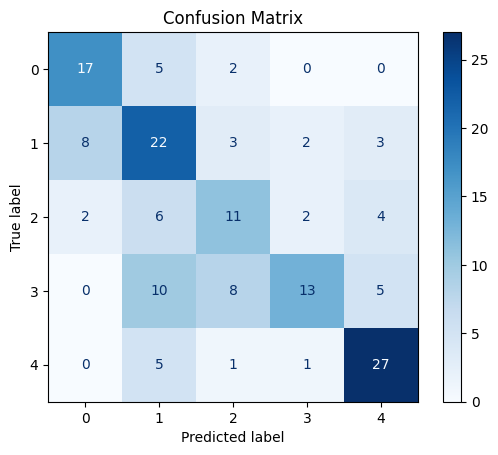

In [24]:
# Membuat confusion matrix model Naive Bayes
cm = confusion_matrix(y_test, Y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [25]:
# SVM
from sklearn import svm
sv = svm.SVC(kernel='linear')
sv.fit(X_train, y_train)
Y_pred_svm = sv.predict(X_test)

score_svm = round(accuracy_score(Y_pred_svm,y_test)*100,2)
print("Akurasi : "+str(score_svm)+" %")

Akurasi : 59.24 %


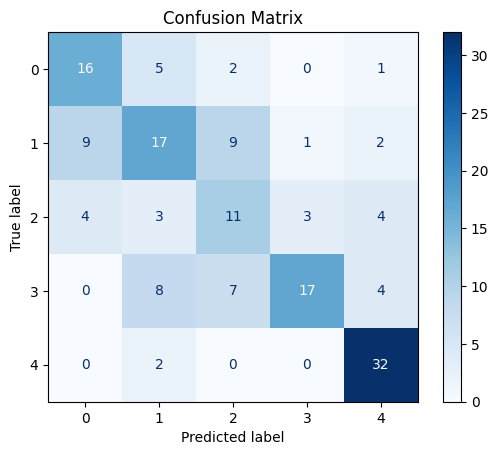

In [26]:
# Membuat confusion matrix model SVM
cm = confusion_matrix(y_test, Y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [27]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
Y_pred_knn=knn.predict(X_test)

score_knn = round(accuracy_score(Y_pred_knn,y_test)*100,2)

print("Akurasi : "+str(score_knn)+" %")

Akurasi : 75.8 %


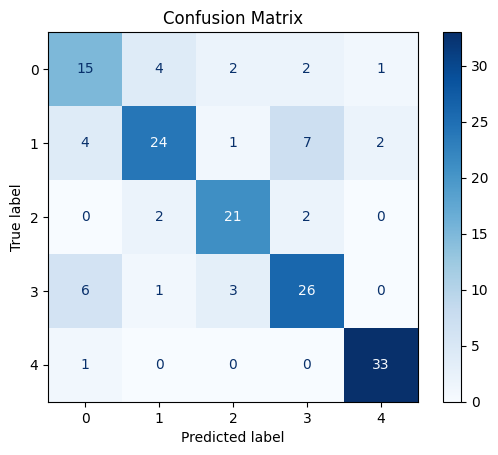

In [28]:
# Membuat confusion matrix model KNN
cm = confusion_matrix(y_test, Y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [29]:
# DECISON TREE
from sklearn.tree import DecisionTreeClassifier

max_accuracy = 0


for x in range(500):
    dt = DecisionTreeClassifier(random_state=x)
    dt.fit(X_train,y_train)
    Y_pred_dt = dt.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_dt,y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        
#print(max_accuracy)
#print(best_x)


dt = DecisionTreeClassifier(random_state=best_x)
dt.fit(X_train,y_train)
Y_pred_dt = dt.predict(X_test)

score_dt = round(accuracy_score(Y_pred_dt,y_test)*100,2)

print("Akurasi : "+str(score_dt)+" %")

Akurasi : 71.34 %


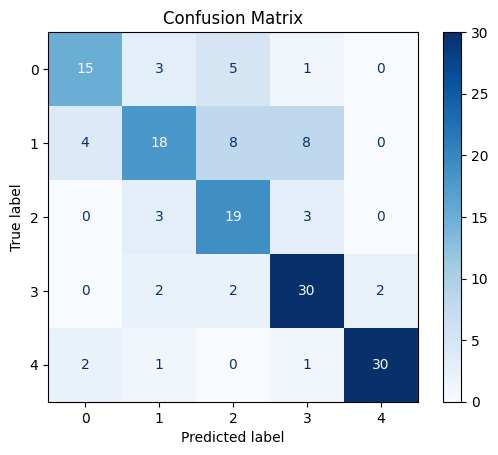

In [33]:
# Membuat confusion matrix model Decision Tree
cm = confusion_matrix(y_test, Y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# RANDOM FOREST
max_accuracy = 0

for x in range(1000):
    rf = RandomForestClassifier(random_state=x)
    rf.fit(X_train,y_train)
    Y_pred_rf = rf.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_rf,y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        
#print(max_accuracy)
#print(best_x)

rf = RandomForestClassifier(random_state=best_x)
rf.fit(X_train,y_train)
Y_pred_rf = rf.predict(X_test)

score_rf = round(accuracy_score(Y_pred_rf,y_test)*100,2)

print("Akurasi : "+str(score_rf)+" %")

In [ ]:
# Membuat confusion matrix model Random Forest
cm = confusion_matrix(y_test, Y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [34]:
# XGBOOST
import xgboost as xgb
from xgboost import XGBClassifier

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

Y_pred_xgb = xgb_model.predict(X_test)

score_xgb = round(accuracy_score(Y_pred_xgb,y_test)*100,2)

print("Akurasi : "+str(score_xgb)+" %")

Akurasi : 84.08 %


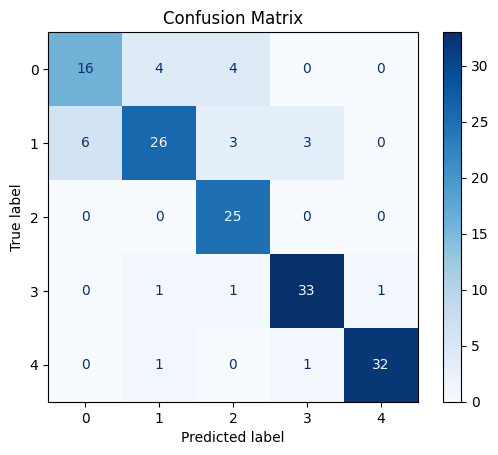

In [35]:
# Membuat confusion matrix model XGBoost
cm = confusion_matrix(y_test, Y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [36]:
scores = [score_lr,score_nb,score_svm,score_knn,score_dt,score_xgb]#,score_rf]
algorithms = ["Logistic Regression","Naive Bayes","Support Vector Machine","K-Nearest Neighbors","Decision Tree","XGBoost"]#,"Random Forest"]    

for i in range(len(algorithms)):
    print("Akurasi Model "+algorithms[i]+" : "+str(scores[i])+" %")

Akurasi Model Logistic Regression : 57.32 %
Akurasi Model Naive Bayes : 57.32 %
Akurasi Model Support Vector Machine : 59.24 %
Akurasi Model K-Nearest Neighbors : 75.8 %
Akurasi Model Decision Tree : 71.34 %
Akurasi Model XGBoost : 84.08 %


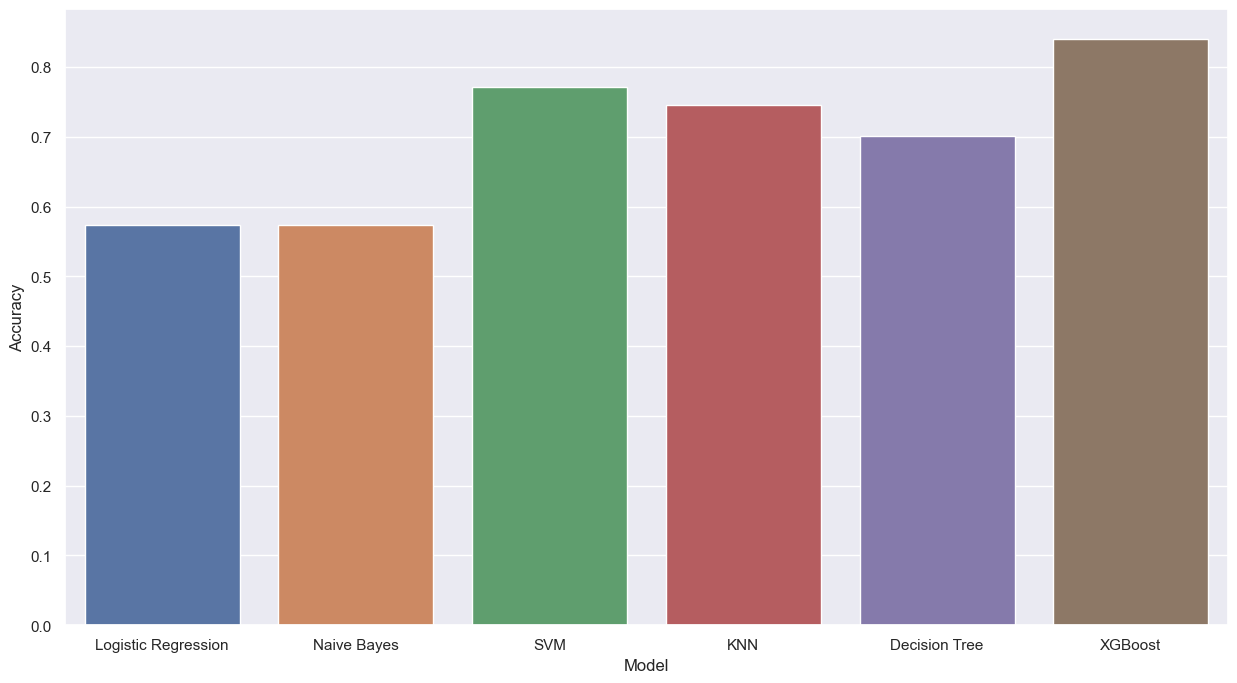

In [37]:
# Membangun dan mengevaluasi berbagai model klasifikasi
models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    #"Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier()
}

# Menyimpan hasil akurasi
results = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append((model_name, accuracy))

# Membuat DataFrame dari hasil
results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])

# Membuat barplot
sns.set(rc={'figure.figsize':(15,8)})
plt.xlabel("Model")
plt.ylabel("Accuracy score")
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.show()